# How to optimize controls on large sparse Hamiltonians
**Efficiently perform control optimization on sparse Hamiltonians**

Boulder Opal exposes a highly-flexible [optimization engine](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/run_optimization) for general-purpose gradient-based optimization.  It can be directly applied to model-based control optimization for arbitrary-dimensional quantum systems. 

This optimization engine provides best-in-class time to solution, but the efficiency of the optimization will always decline with the system size.
In cases where the Hamiltonian to be treated is sparse it is possible to recover performance via specialized methods.
In this user guide we demonstrate the use of sparse-Hamiltonian methods for efficient optimizations in large systems.
To learn the basics about control optimization, you can follow our [robust optimization tutorial](https://docs.q-ctrl.com/boulder-opal/tutorials/design-robust-single-qubit-gates-using-computational-graphs).

## Summary workflow

### 1. Define system Hamiltonian with a sparse representation

The flexible Boulder Opal optimization engine expresses all optimization problems as data flow graphs, which describe how optimization variables (variables that can be tuned by the optimizer) are transformed into the cost function (the objective that the optimizer attempts to minimize). 

You can carry out the optimization of larger systems by using approximate integration methods that are more computationally effective than standard approaches.
This is especially helpful when the Hamiltonian is sparse.

Here you can define system Hamiltonian terms with a sparse representation with operations such as `graph.sparse_pwc_operator` or `graph.constant_sparse_pwc_operator`.
These accept an operator as a Tensor or as a sparse matrix (for example, as a [`scipy.sparse.coo_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html)).

### 2. Use sparse-matrix methods in the computational graph

You can then integrate the Schrödinger equation using the [Lanczos algorithm](https://en.wikipedia.org/wiki/Lanczos_algorithm) that is available in the operation `graph.state_evolution_pwc`.
The Lanczos algorithm accepts a parameter called the `krylov_subspace_dimension`, which controls the accuracy of the operation.
You can choose this parameter manually or use the operation `graph.estimated_krylov_subspace_dimension_lanczos` to obtain an estimate of its best choice for your Hamiltonian and error tolerance.

All of these calculations are performed within the optimization graph.

### 3. Run graph-based optimization

With the graph object created, an optimization can be run using the `boulderopal.run_optimization` function. The cost, the outputs, and the graph must be provided. The function returns the results of the optimization. Note that this example code block uses naming that should be replaced with the naming used in your graph.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qctrlvisualizer as qv
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

## Example: Optimized controls in a nearest-neighbor-coupled qubit chain

 To illustrate this, consider a system of four qubits where each qubit only interacts with the nearest neighbor through an XX coupling operator:

$$ H = \frac{1}{2} \sum_{i=1}^3 \Omega_i(t) \sigma_{x,i} \sigma_{x,i+1}. $$

Suppose you start from the state $\left| 0000 \right\rangle$ and want to create the state $\left(\left| 0000 \right\rangle +i\left| 0011 \right\rangle -i\left| 1100 \right\rangle+ \left| 1111 \right\rangle \right)/2$ by using optimized controls for $\Omega_1(t)$, $\Omega_2(t)$, and $\Omega_3(t)$.

The following code uses spare-matrix techniques and Lanczos algorithm to obtain an estimate for an integration accuracy of `1e-5` and then how to optimize the controls using it. The code also prints a comparison between the integration that uses the Lanczos algorithm and the exact integration, as well as the optimized controls.

Your task (action_id="1828668") has completed.
Your task (action_id="1828669") has started.
Your task (action_id="1828669") has completed.

Recommended Krylov subspace dimension:	10
Final state infidelity: 1.110e-14 (Lanczos integration)
Final state infidelity: -1.217e-13 (Exact integration)


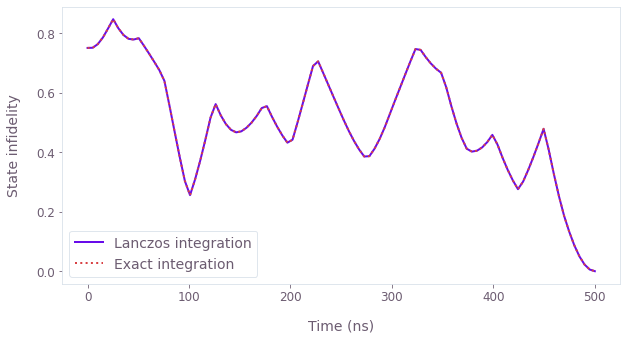

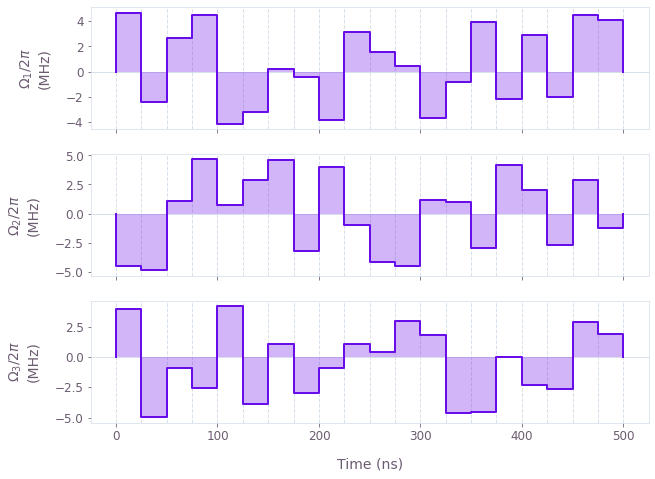

In [2]:
# Define physical constraints.
omega_max = 2 * np.pi * 5e6  # rad/s
duration = 500e-9  # s
segment_count = 20
sample_times = np.linspace(0, duration, 100)
target_state = np.zeros(2**4, complex)
target_state[int("0000", 2)] = 1 / 2
target_state[int("0011", 2)] = 1j / 2
target_state[int("1100", 2)] = -1j / 2
target_state[int("1111", 2)] = 1 / 2


# Define coupling operators.
def create_operators(graph):
    sigma_x = graph.pauli_matrix("X")
    return [
        0.5 * graph.embed_operators([(sigma_x, n), (sigma_x, n + 1)], [2] * 4)
        for n in range(3)
    ]


# Build graph to estimate the Krylov subspace dimension.
graph = bo.Graph()

# Find the spectral range for the Hamiltonian with highest omega value.
spectral_range = graph.spectral_range(operator=omega_max * sum(create_operators(graph)))

# Find the suggested Krylov subspace dimension for that spectral range
# with an error tolerance of 1e-5.
graph.estimated_krylov_subspace_dimension_lanczos(
    spectral_range=spectral_range,
    duration=duration,
    maximum_segment_duration=duration / segment_count,
    error_tolerance=1e-5,
    name="krylov_subspace_dimension",
)

# Estimate recommended Krylov subspace dimension.
krylov_subspace_dimension = bo.execute_graph(
    graph=graph, output_node_names="krylov_subspace_dimension"
)["output"]["krylov_subspace_dimension"]["value"]

# Build optimization graph.
graph = bo.Graph()

# Define initial state.
initial_state = graph.fock_state(16, 0)

# Define individual control signals (Omegas).
signals = [
    graph.real_optimizable_pwc_signal(
        segment_count=segment_count,
        minimum=-omega_max,
        maximum=omega_max,
        duration=duration,
        name=rf"$\Omega_{n+1}$",
    )
    for n in range(3)
]

# Define individual terms of the Hamiltonian.
operators = create_operators(graph)
sparse_hamiltonian_terms = [
    graph.sparse_pwc_operator(signal=signal, operator=operator)
    for signal, operator in zip(signals, operators)
]

# Create total Hamiltonian by adding terms.
hamiltonian = graph.sparse_pwc_sum(sparse_hamiltonian_terms)

# Integrate the Schrödinger equation for the Hamiltonian,
# using the recommended choice of Krylov subspace dimension.
evolved_states = graph.state_evolution_pwc(
    initial_state=initial_state,
    hamiltonian=hamiltonian,
    krylov_subspace_dimension=krylov_subspace_dimension,
    sample_times=sample_times,
)

# Calculate the infidelities as a function of time.
sparse_infidelities = graph.state_infidelity(
    evolved_states, target_state, name="sparse_infidelities"
)

# Use the final state infidelity as the cost.
final_state_infidelity = sparse_infidelities[-1]
final_state_infidelity.name = "cost"

# Calculate the evolution using a dense Hamiltonian, for comparison.
dense_hamiltonian_terms = [
    signal * operator for signal, operator in zip(signals, operators)
]
dense_hamiltonian = graph.pwc_sum(dense_hamiltonian_terms)
time_evolution_operators = graph.time_evolution_operators_pwc(
    hamiltonian=dense_hamiltonian, sample_times=sample_times
)
dense_evolved_states = time_evolution_operators @ initial_state[:, None]
dense_infidelities = graph.state_infidelity(
    dense_evolved_states[..., 0], target_state, name="dense_infidelities"
)

# Run optimization.
result = bo.run_optimization(
    graph=graph,
    cost_node_name="cost",
    output_node_names=["sparse_infidelities", "dense_infidelities"]
    + [rf"$\Omega_{n+1}$" for n in range(3)],
    optimization_count=5,
)

# Extract time-dependent infidelities.
sparse_infidelities = result["output"].pop("sparse_infidelities")["value"].flatten()
dense_infidelities = result["output"].pop("dense_infidelities")["value"].flatten()

# Plot and print results.
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sample_times / 1e-9, sparse_infidelities, label="Lanczos integration")
ax.plot(sample_times / 1e-9, dense_infidelities, ":", label="Exact integration")
ax.legend()
ax.set_xlabel("Time (ns)")
ax.set_ylabel("State infidelity")

print(f"\nRecommended Krylov subspace dimension:\t{krylov_subspace_dimension}")
print(f"Final state infidelity: {result['cost']:.3e} (Lanczos integration)")
print(f"Final state infidelity: {dense_infidelities[-1]:.3e} (Exact integration)")

qv.plot_controls(result["output"])

Comparison between the time evolution of the infidelity using the Lanczos and exact integrations (top). The difference between them is well within the `1e-5` accuracy. Optimized pulses obtained to generate the target state (bottom).